In [3]:
import numpy as np

# Define the likelihood functions for GR and NG, assuming Gaussian likelihoods
def likelihood_GR(x):
    return np.exp(-(x - 1.74)**2 / (2*0.4**2))

def likelihood_NG(x):
    return np.exp(-(x - 0.87)**2 / (2*0.16**2))

# Calculate the likelihood of the data under each theory, using Eddington's and Crommelin's measurements
L_GR = likelihood_GR(1.61) * likelihood_GR(1.98)
L_NG = likelihood_NG(1.61) * likelihood_NG(1.98)

# Calculate the Bayes factor
prior_odds_GR = 1
prior_odds_NG = 1
bayes_factor = (L_GR / L_NG) * (prior_odds_GR / prior_odds_NG)

print("Bayes factor = {}".format(bayes_factor))
print("Posterior odds = {}".format(1/bayes_factor))


Bayes factor = 988246350295380.6
Posterior odds = 1.0118934410444382e-15


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astroML
from astroML.stats import sigmaG
import pandas as pd
import seaborn as sns

In [2]:
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

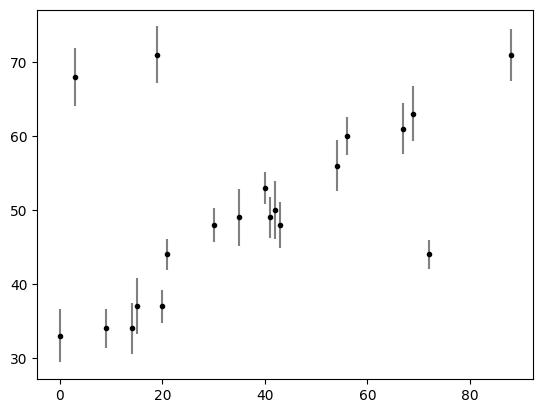

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.errorbar(x, y, e, fmt='.k', ecolor='gray');

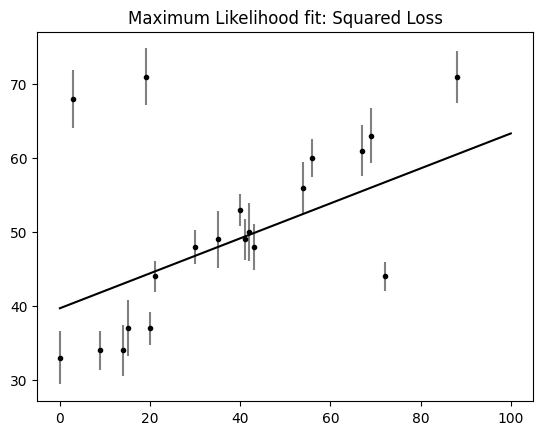

In [4]:
from scipy import optimize

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Maximum Likelihood fit: Squared Loss');

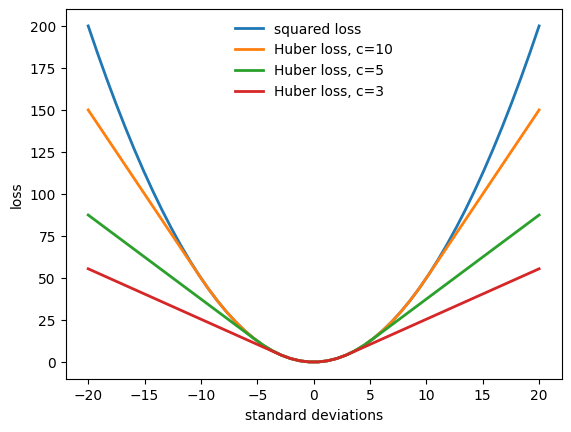

In [5]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

plt.plot(t, 0.5 * t ** 2, label="squared loss", lw=2)
for c in (10, 5, 3):
    plt.plot(t, huber_loss(t, c), label="Huber loss, c={0}".format(c), lw=2)
plt.ylabel('loss')
plt.xlabel('standard deviations')
plt.legend(loc='best', frameon=False);

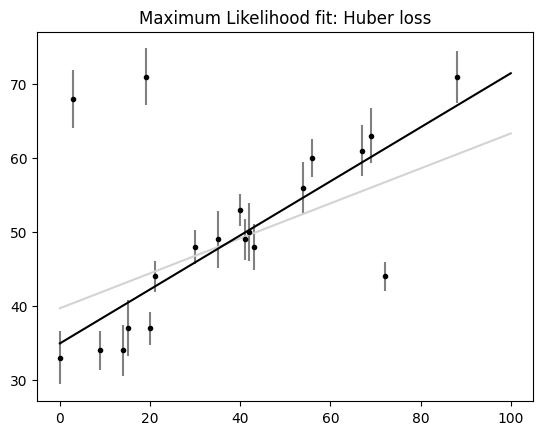

In [6]:
def total_huber_loss(theta, x=x, y=y, e=e, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.title('Maximum Likelihood fit: Huber loss');

In [7]:
# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

In [8]:
# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

/tmp/ipykernel_682/2307609539.py:16: RuntimeWarning: divide by zero encountered in log
  logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
/tmp/ipykernel_682/2307609539.py:15: RuntimeWarning: divide by zero encountered in log
  logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2


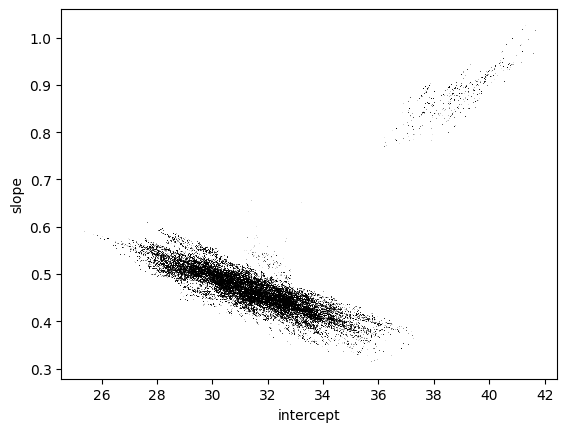

In [9]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

g1 mean: 0.61
g2 mean: 0.37


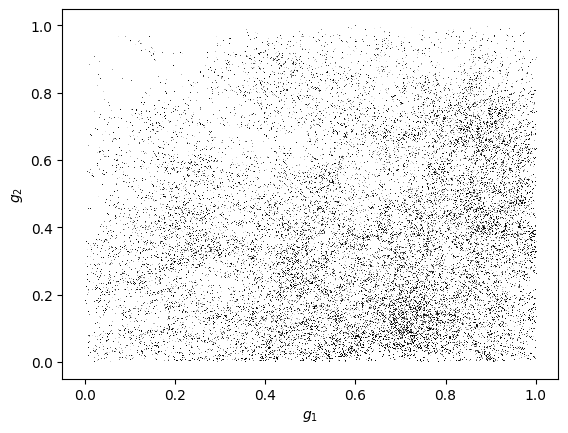

In [10]:
plt.plot(sample[:, 2], sample[:, 3], ',k', alpha=0.1)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))

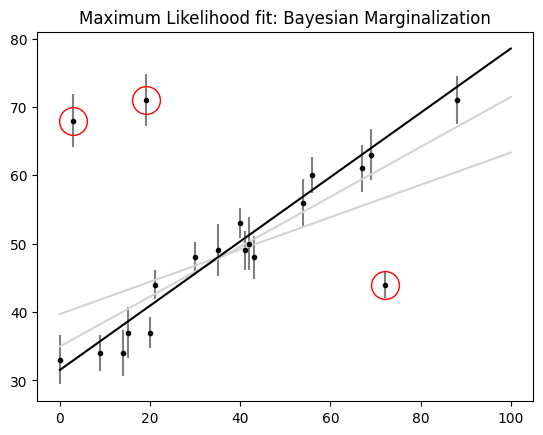

In [11]:
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.5)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='lightgray')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Maximum Likelihood fit: Bayesian Marginalization');